<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Playground Season 3: Episode 1</h1>
</div>


## Problem Type

Linear Regression

## Evaluation Metric

[RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)

$$RMSE = \sqrt{ \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2}$$

## Resources

### Discussions

- [Lat / Long Feature Engineering](https://www.kaggle.com/competitions/playground-series-s3e1/discussion/376210)
- [Working with (Latitude, Longitude) data](https://www.kaggle.com/competitions/playground-series-s3e1/discussion/376121)
- [This is why Longitude/Latitude are the most important Features](https://www.kaggle.com/competitions/playground-series-s3e1/discussion/376078)
- [Feature engineering ideas](https://www.kaggle.com/competitions/playground-series-s3e1/discussion/375859)
- [Highly Correlated Cartesian Coordinate Features](https://www.kaggle.com/competitions/playground-series-s3e1/discussion/376364)
  - Exclude rot_30_y due to correlation issues
- [Clip Max (Boost +0.003)](https://www.kaggle.com/competitions/playground-series-s3e1/discussion/376396)

### Notebooks

- [PS S3E1 | Coordinates - key to victory](https://www.kaggle.com/code/dmitryuarov/ps-s3e1-coordinates-key-to-victory)
  - Lots of Feature Engineering: rot_15_x, rot_15_y, ...
- [Playground series - xgboost baseline](https://www.kaggle.com/code/ranjeetshrivastav/playground-series-xgboost-baseline)
- [Distance to Cities features & Clustering](https://www.kaggle.com/code/phongnguyen1/distance-to-cities-features-clustering)  
- [Regression prediction intervals with MAPIE](https://www.kaggle.com/code/carlmcbrideellis/regression-prediction-intervals-with-mapie)
- [playground s03e01 - top 5% CatBoost & LGBM](https://www.kaggle.com/code/directt/playground-s03e01-top-5-catboost-lgbm)
- [PS-S3-Ep1 | EDA | FE | Modeling](https://www.kaggle.com/code/oscarm524/ps-s3-ep1-eda-fe-modeling)
- [S03E01: EDA for Modelling ](https://www.kaggle.com/code/soupmonster/s03e01-eda-for-modelling)
- [[S03E01] Linear and Non-Linear Regression](https://www.kaggle.com/code/sejoongkim/s03e01-linear-and-non-linear-regression)


<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Import Libraries</h1>
</div>

In [5]:
!pip install missingno

  Using cached missingno-0.5.1-py3-none-any.whl (8.7 kB)


In [7]:
!pip install folium

  Using cached folium-0.14.0-py2.py3-none-any.whl (102 kB)
  Using cached branca-0.6.0-py3-none-any.whl (24 kB)


In [8]:
from typing import List, Set, Dict, Tuple, Optional

import os
import time
from pathlib import Path
import glob
import gc

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn import impute
from sklearn import metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import model_selection
from sklearn import ensemble
from sklearn import datasets

import xgboost as xgb
import catboost as cb
import lightgbm as lgb

from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Visualization Libraries
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import missingno as msno
from folium import Map
from folium.plugins import HeatMap


<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Configuration</h1>
</div>

In [9]:
TARGET="MedHouseVal"

In [10]:
class Config:
    path:str = ""
    gpu:bool = True
    fast_render:bool = False
    calc_probability:bool = True
    seed:int = 42
    N_ESTIMATORS:int = 1000  # 100, 300, 1000, 2000, 5000, 15_000, 20_000 GBDT
    
    N_FOLDS:int = 10

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Theme</h1>
</div>

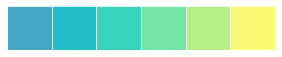

In [11]:
mpl.rcParams["font.size"] = 16

theme_colors = ["#44A7C4", "#20BEC7", "#38D3BB", "#73E4A3", "#B3F186", "#F9F871"]
theme_palette = sns.set_palette(sns.color_palette(theme_colors))

sns.palplot(sns.color_palette(theme_colors), size=0.8)
plt.tick_params(axis="both", labelsize=0, length=0)

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Library</h1>
</div>

Creating a few functions that will be reused in each project.

I need to be better with [DRY](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself) on Kaggle.

In [12]:
def read_data(path: str, analyze:bool=True) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    submission_df = pd.read_csv(data_dir / "sample_submission.csv")

    if analyze:
        print("=== Shape of Data ===")
        print(f" train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
        print(f" test data : Rows={test.shape[0]}, Columns={test.shape[1]}")

        print("\n=== Train Data: First 5 Rows ===\n")
        display(train.head())
        print("\n=== Train Column Names ===\n")
        display(train.columns)
        print("\n=== Features/Explanatory Variables ===\n")
        eval_features(train)
        print("\n === Skewness ===\n")
        check_skew(train)
    return train, test, submission_df

def create_submission(model_name: str, target, preds, seed:int=42, nfolds:int=5) -> pd.DataFrame:
    sample_submission[target] = preds

    if len(model_name) > 0:
        fname = f"submission_{model_name}_k{nfolds}_s{seed}.csv"
    else:
        fname = "submission.csv"

    sample_submission.to_csv(fname, index=False)

    return sample_submission

def show_classification_scores(gt:List[int], yhat:List[int]) -> None:
    accuracy = accuracy_score(gt, yhat)
    precision = precision_score(gt, yhat)
    recall = recall_score(gt, yhat)
    f1 = f1_score(gt, yhat)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"f1: {f1:.4f}")
    

def label_encoder(train:pd.DataFrame, test:pd.DataFrame, columns:List[str]) -> (pd.DataFrame, pd.DataFrame) :
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = preprocessing.LabelEncoder().fit_transform(train[col])
        test[col] = preprocessing.LabelEncoder().fit_transform(test[col])
    return train, test   

def create_strat_folds(df:pd.DataFrame, TARGET, n_folds:int=5, seed:int=42) -> pd.DataFrame:
    print(f"TARGET={TARGET}, n_folds={n_folds}, seed={seed}")
    df["fold"] = -1

    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    # kf = GroupKFold(n_splits=Config.N_FOLDS)
    for fold, (train_idx, valid_idx) in enumerate(kf.split(df, df[TARGET])):
        df.loc[valid_idx, "fold"] = fold

    # df.to_csv(f"train_fold{num_folds}.csv", index=False)
    return df


def create_folds(df:pd.DataFrame, n_folds:int=5, seed:int=42) -> pd.DataFrame:
    print(f"n_folds={n_folds}, seed={seed}")
    df["fold"] = -1

    #  kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df.values)


    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(df)):
        df.loc[valid_idx, "fold"] = fold

    # df.to_csv(f"train_fold{num_folds}.csv", index=False)
    return df

def show_fold_scores(scores: List[float]) -> (float, float):
    cv_score = np.mean(scores)  # Used in filename
    std_dev = np.std(scores)
    print(
        f"Scores -> Adjusted: {np.mean(scores) - np.std(scores):.8f} , mean: {np.mean(scores):.8f}, std: {np.std(scores):.8f}"
    )
    return cv_score, std_dev


def feature_distribution_types(df:pd.DataFrame, display:bool=True) -> (List[str], List[str]):
    continuous_features = list(df.select_dtypes(include=['int64', 'float64', 'uint8']).columns)
    categorical_features = list(df.select_dtypes(include=['object', 'bool']).columns)
    if display:
        print(f"Continuous Features={continuous_features}\n")
        print(f"Categorical Features={categorical_features}")
    return continuous_features, categorical_features   

def show_cardinality(df:pd.DataFrame, features:List[str]) -> None:
    print("=== Cardinality ===")
    print(df[features].nunique())

## === Model Support ===    

from scipy.stats import mode


def merge_test_predictions(final_test_predictions:List[float], calc_probability:bool=True) -> List[float]:

    if Config.calc_probability:
        print("Mean")
        result = np.mean(np.column_stack(final_test_predictions), axis=1)
    else:
        print("Mode")
        mode_result = mode(np.column_stack(final_test_predictions), axis=1)
        result = mode_result[0].ravel()

    return result    

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">EDA Library</h1>
</div>

In [13]:
def summary_statistics(X:pd.DataFrame, enhanced=True) -> None:
    desc = X.describe()
    if enhanced:
        desc.loc["var"] = X.var(numeric_only=True).tolist()
        desc.loc["skew"] = X.skew(numeric_only=True).tolist()
        desc.loc["kurt"] = X.kurtosis(numeric_only=True).tolist()

    with pd.option_context("display.precision", 2):
        style = desc.transpose().style.background_gradient(
            cmap="coolwarm"
        )  # .set_precision(4)
    display(style)
    
def show_missing_features(df:pd.DataFrame) -> None:
    missing_vals = df.isna().sum().sort_values(ascending=False)
    print(missing_vals[missing_vals > 0])


def show_duplicate_records(df:pd.DataFrame) -> None:
    dups = df.duplicated()
    print(dups.sum())


def eval_features(df:pd.DataFrame) -> (List[str], List[str], List[str]):
    ## Separate Categorical and Numerical Features
    categorical_features = list(
        df.select_dtypes(include=["category", "object"]).columns
    )
    continuous_features = list(df.select_dtypes(include=["number"]).columns)

    print(f"Continuous features: {continuous_features}")
    print(f"Categorical features: {categorical_features}")
    print("\n --- Cardinality of Categorical Features ---\n")

    for feature in categorical_features:
        cardinality = df[feature].nunique()
        if cardinality < 10:
            print(f"{feature}: cardinality={cardinality}, {df[feature].unique()}")
        else:
            print(f"{feature}: cardinality={cardinality}")
    all_features = categorical_features + continuous_features
    return all_features, categorical_features, continuous_features


def show_feature_importance(feature_importance_lst:List[str]) -> None:
    fis_df = pd.concat(feature_importance_lst, axis=1)

    fis_df.sort_values("0_importance", ascending=True).head(40).plot(
        kind="barh", figsize=(12, 12), title="Feature Importance Across Folds"
    )
    plt.show()


def show_feature_target_crosstab(df:pd.DataFrame, feature_lst:List[str], target:str) -> None:
    for feature in feature_lst:
        print(f"\n=== {feature} vs {target} ===\n")
        display(
            pd.crosstab(df[feature], df[target], margins=True)
        )  # display keeps bold formatting


def show_cardinality(df:pd.DataFrame, features:List[str]) -> None:
    print("=== Cardinality ===")
    print(df[features].nunique())


def show_unique_features(df:pd.DataFrame, features:List[str]) -> None:
    for col in features:
        print(col, sorted(df[col].dropna().unique()))


def feature_distribution_types(df:pd.DataFrame, display:bool=True) -> (List[str], List[str]):
    continuous_features = list(
        df.select_dtypes(include=["int64", "float64", "uint8"]).columns
    )
    categorical_features = list(df.select_dtypes(include=["object", "bool"]).columns)
    if display:
        print(f"Continuous Features={continuous_features}\n")
        print(f"Categorical Features={categorical_features}")
    return continuous_features, categorical_features

def describe(X:pd.DataFrame) -> None:
    "Deprecated: Use summary_statistics()"
    desc = X.describe()
    desc.loc['var'] = X.var(numeric_only=True).tolist()
    desc.loc['skew'] = X.skew(numeric_only=True).tolist()
    desc.loc['kurt'] = X.kurtosis(numeric_only=True).tolist()

    with pd.option_context('display.precision', 2):
        style = desc.transpose().style.background_gradient(cmap='coolwarm') #.set_precision(4)
    display(style)
    
def check_skew(df:pd.DataFrame) -> None:
    skew = df.skew(skipna=True,numeric_only=True).sort_values(ascending=False)
    print(skew)

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Load Train/Test Data and Analyze</h1>
</div>

## Load the following files

 - train.csv - Data used to build our machine learning model
 - test.csv - Data used to build our machine learning model. Does not contain the target variable
 - sample_submission.csv - A file in the proper format to submit test predictions

In [14]:
%%time
train, test, sample_submission = read_data(Config.path)

=== Shape of Data ===
 train data: Rows=37137, Columns=10
 test data : Rows=24759, Columns=9

=== Train Data: First 5 Rows ===



,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500



=== Train Column Names ===



Index(['id', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')


=== Features/Explanatory Variables ===

Continuous features: ['id', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']
Categorical features: []

 --- Cardinality of Categorical Features ---


 === Skewness ===

AveOccup       170.890130
AveBedrms       12.965449
Population       5.796582
MedInc           1.567604
AveRooms         1.301106
MedHouseVal      0.970856
Latitude         0.439251
HouseAge         0.413457
id               0.000000
Longitude       -0.313242
dtype: float64
CPU times: user 57.9 ms, sys: 13.2 ms, total: 71.1 ms
Wall time: 72.1 ms


<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Preprocessing</h1>
</div>

## Categorical/Numerical Variables

In [15]:
cont_features, cat_features = feature_distribution_types(train, display=True)
show_cardinality(train, cat_features)

cont_features.remove(TARGET)
cont_features.remove("id")
FEATURES = cont_features + cat_features
FEATURES

Continuous Features=['id', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']

Categorical Features=[]
=== Cardinality ===
Series([], dtype: float64)


['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

## No Missing Data

Since there's no missing data, skipping the graphs, output, etc

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">EDA</h1>
</div>

### Distributions of Continuous Features

In [16]:
def plot_continuous_features(train:pd.DataFrame, test:pd.DataFrame, continuous_features:List[str], nrows:int, ncols:int):
    plt.figure()
    fig, ax = plt.subplots(2, 2, figsize=(20, 22))

    for i, feature in enumerate(continuous_features):
#         print(f"Feature: {feature}")
        plt.subplot(nrows, ncols, i + 1)
        sns.histplot(
            x=feature, color="blue", kde=True, bins=10, label="train_" + feature, data=train
        )
        sns.histplot(
            x=feature, color="olive", kde=True, bins=10, label="test_" + feature, data=test
        )
        plt.xlabel(feature, fontsize=9)
        plt.legend()
    plt.show()
    


<Figure size 432x288 with 0 Axes>

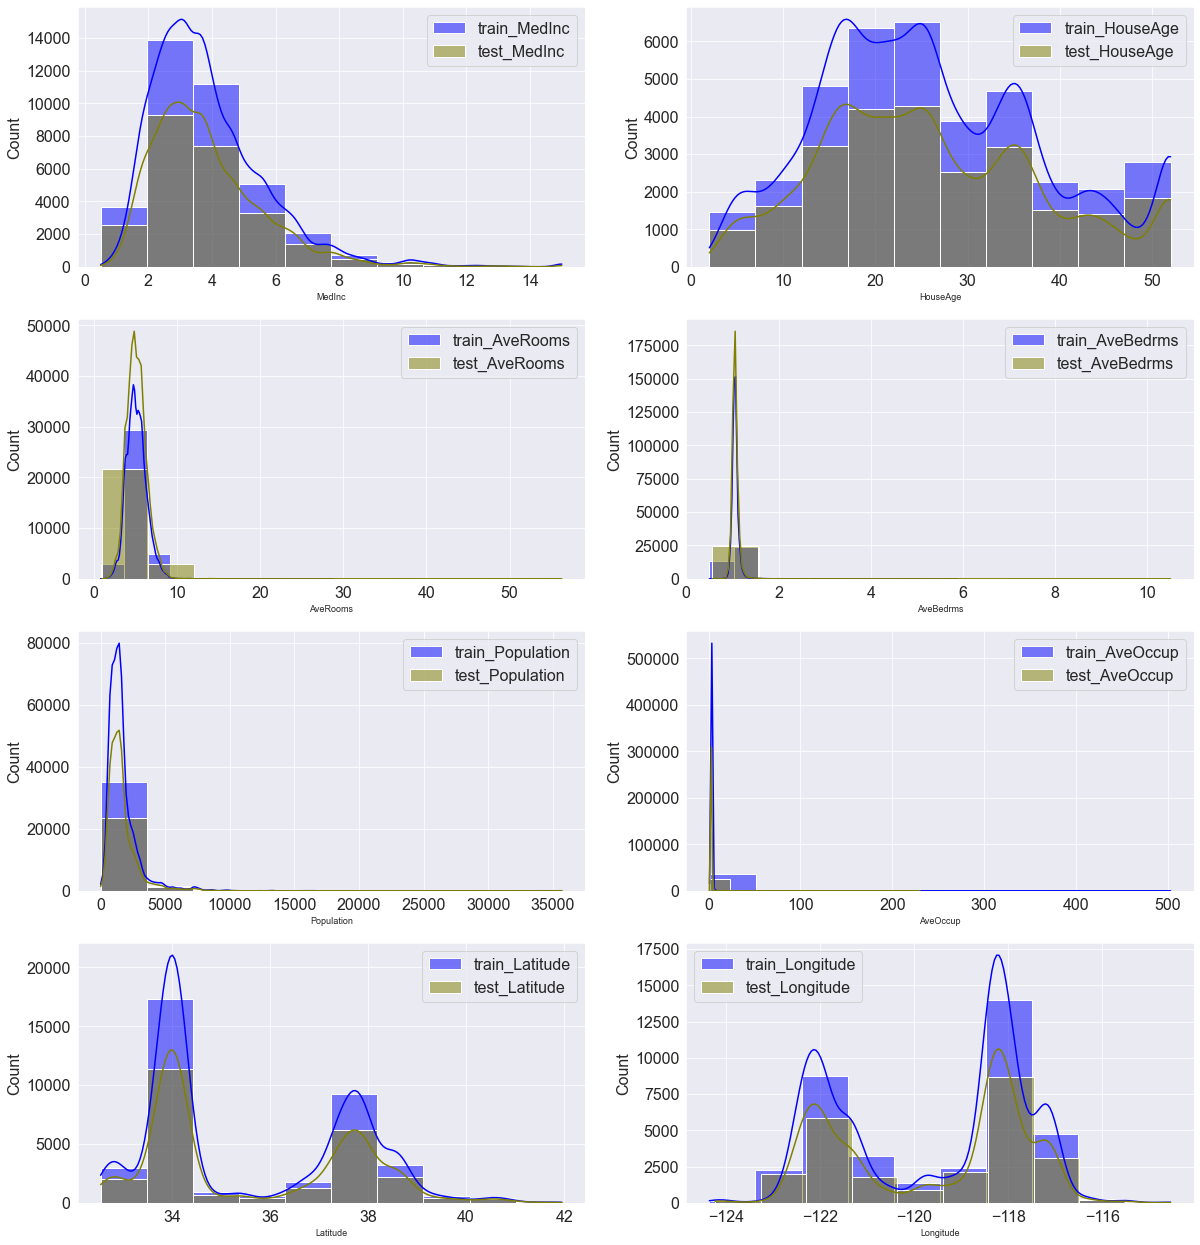

CPU times: user 4.92 s, sys: 1.36 s, total: 6.28 s
Wall time: 3.09 s


In [17]:
%%time
plot_continuous_features(train,test,cont_features,4,2)

### Look for Outliers

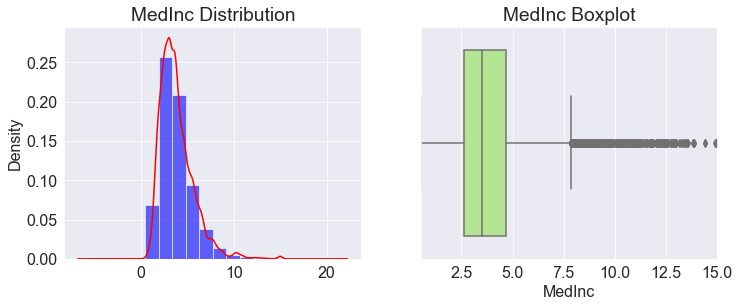

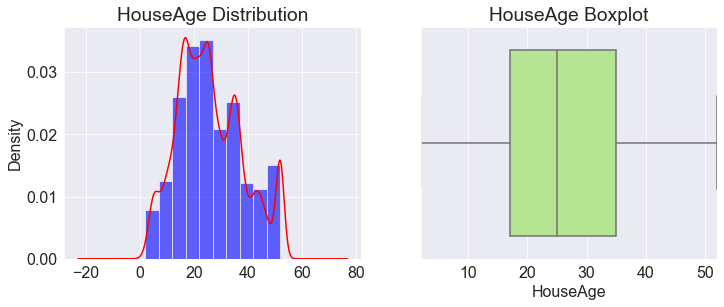

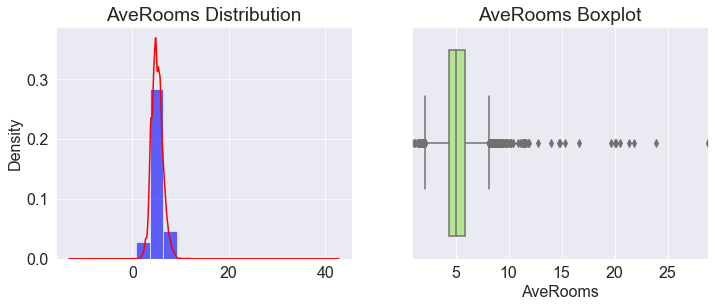

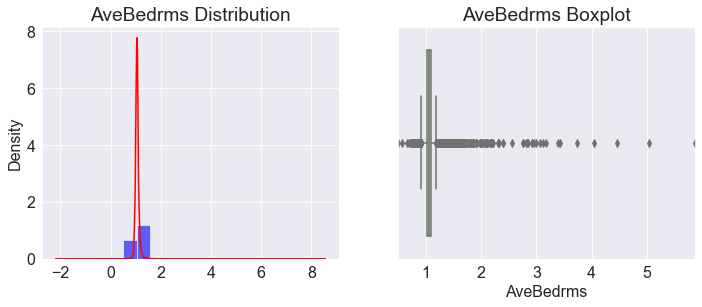

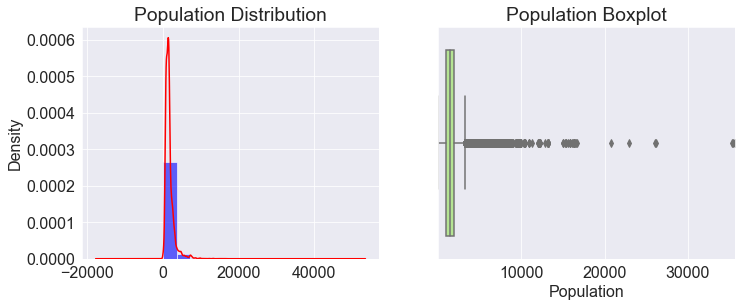

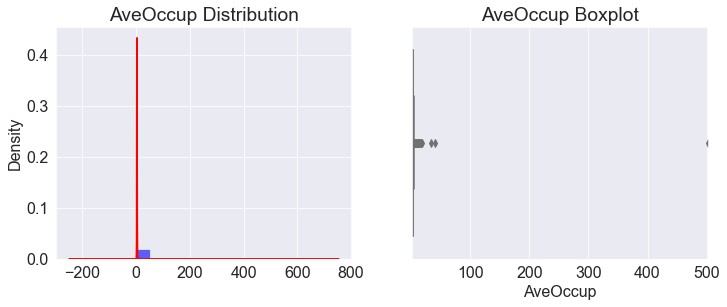

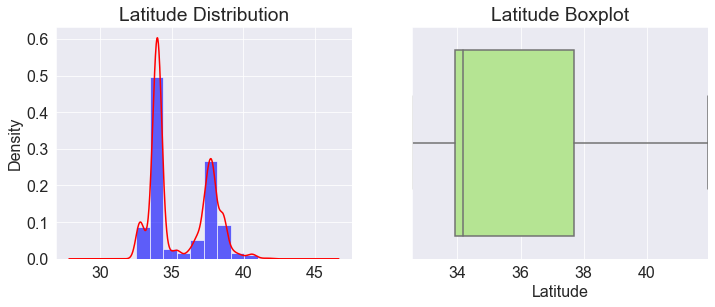

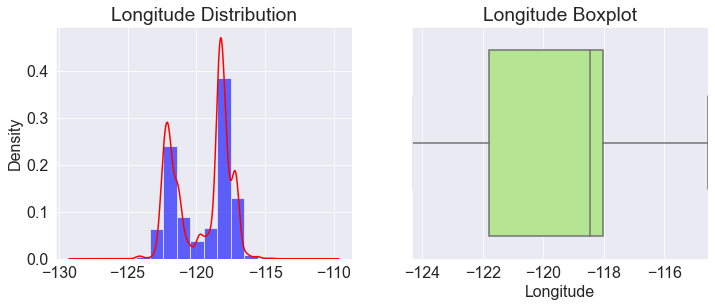

In [18]:
def plot_hist_bloxplot(df:pd.DataFrame, feature:str) -> None:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

#     plt.figure(figsize=(6,4))
    fig.set_size_inches(10, 4)

    ax = df[feature].hist(
        bins=10,
        density=True,
        stacked=True,
        color="blue",
        alpha=0.6,
        ax=axs[0],
        figsize=(6,4)

    )
    df[feature].plot(
        kind="density",
        color="red",
        title=f"{feature} Distribution",
        ax=axs[0]
    )

    min = df[feature].min()
    max = df[feature].max()
    plt.xlim(min, max)

    # plt.figure(figsize=(12,4))
    fig.set_size_inches(11.7, 4.27)
    sns.boxplot(data=df, 
                x=feature,
                color=theme_colors[4],
                ax=axs[1],
    #             figsize=(12,4)
               )
    axs[1].set_title(f'{feature} Boxplot')
    plt.show()

for feature in cont_features:
    plot_hist_bloxplot(train, feature)   
# plot_hist_bloxplot(train, "HouseAge")  

<AxesSubplot:xlabel='AveBedrms'>

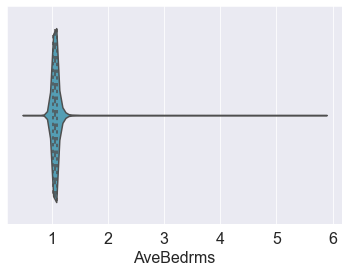

In [19]:
# sns.violin_plot(train, TARGET, cont_features)
sns.violinplot(x='AveBedrms', inner='quartile', data=train) # , ax=ax[0][2])

### Summary Statistics

In [20]:
summary_statistics(train.drop(columns=["id"], axis=1), enhanced=True)

,count,mean,std,min,25%,50%,75%,max,var,skew,kurt
MedInc,37137.000000,3.851029,1.803167,0.499900,2.602300,3.515600,4.699700,15.000100,3.251412,1.567604,4.487282
HouseAge,37137.000000,26.057005,12.158221,2.000000,17.000000,25.000000,35.000000,52.000000,147.822337,0.413457,-0.488224
AveRooms,37137.000000,5.163124,1.206242,0.851064,4.357522,5.068611,5.858597,28.837607,1.455020,1.301106,14.711018
AveBedrms,37137.000000,1.062204,0.096490,0.500000,1.020305,1.054545,1.088825,5.873181,0.009310,12.965449,407.644799
Population,37137.000000,1660.778919,1302.469608,3.000000,952.000000,1383.000000,1856.000000,35682.000000,1696427.078672,5.796582,87.059447
AveOccup,37137.000000,2.831243,2.702413,0.950000,2.394495,2.744828,3.125313,502.990610,7.303035,170.890130,31599.813086
Latitude,37137.000000,35.570030,2.083179,32.550000,33.930000,34.190000,37.700000,41.950000,4.339633,0.439251,-1.268805
Longitude,37137.000000,-119.554329,1.974028,-124.350000,-121.800000,-118.450000,-118.020000,-114.550000,3.896787,-0.313242,-1.452122
MedHouseVal,37137.000000,2.079751,1.158571,0.149990,1.208000,1.808000,2.660000,5.000010,1.342286,0.970856,0.308504


### Correlation Heatmap

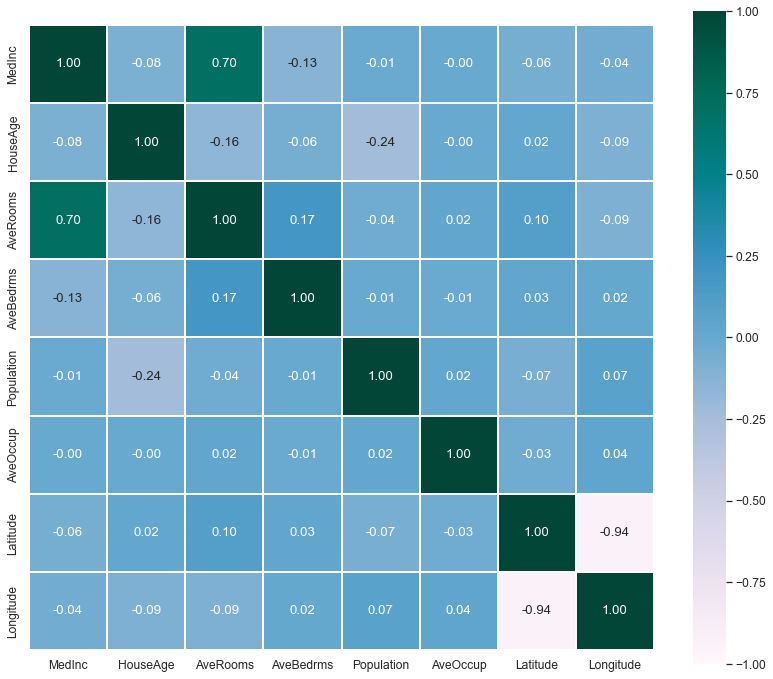

CPU times: user 252 ms, sys: 15.2 ms, total: 267 ms
Wall time: 269 ms


In [21]:
%%time

corr = train[cont_features].corr()
mask = np.triu(train[cont_features].corr())

# cont_features = list(train.select_dtypes(exclude=["object","bool"]))

sns.set(font_scale=1.1)
# plt.figure(figsize=(8, 8), dpi=240)
f,ax = plt.subplots(figsize=(14,12))
sns.heatmap(corr, 
            annot=True, 
            fmt='.2f', 
            cmap='PuBuGn', # ('PuBuGn', 'coolwarm', 'seismic')
            square=True, 
#             mask=mask, 
            linewidths=2,
            cbar=True,  # Show color bar at right
            vmin = -1,
            vmax = 1,
            ax=ax
           )
plt.show()

### Pair Plot

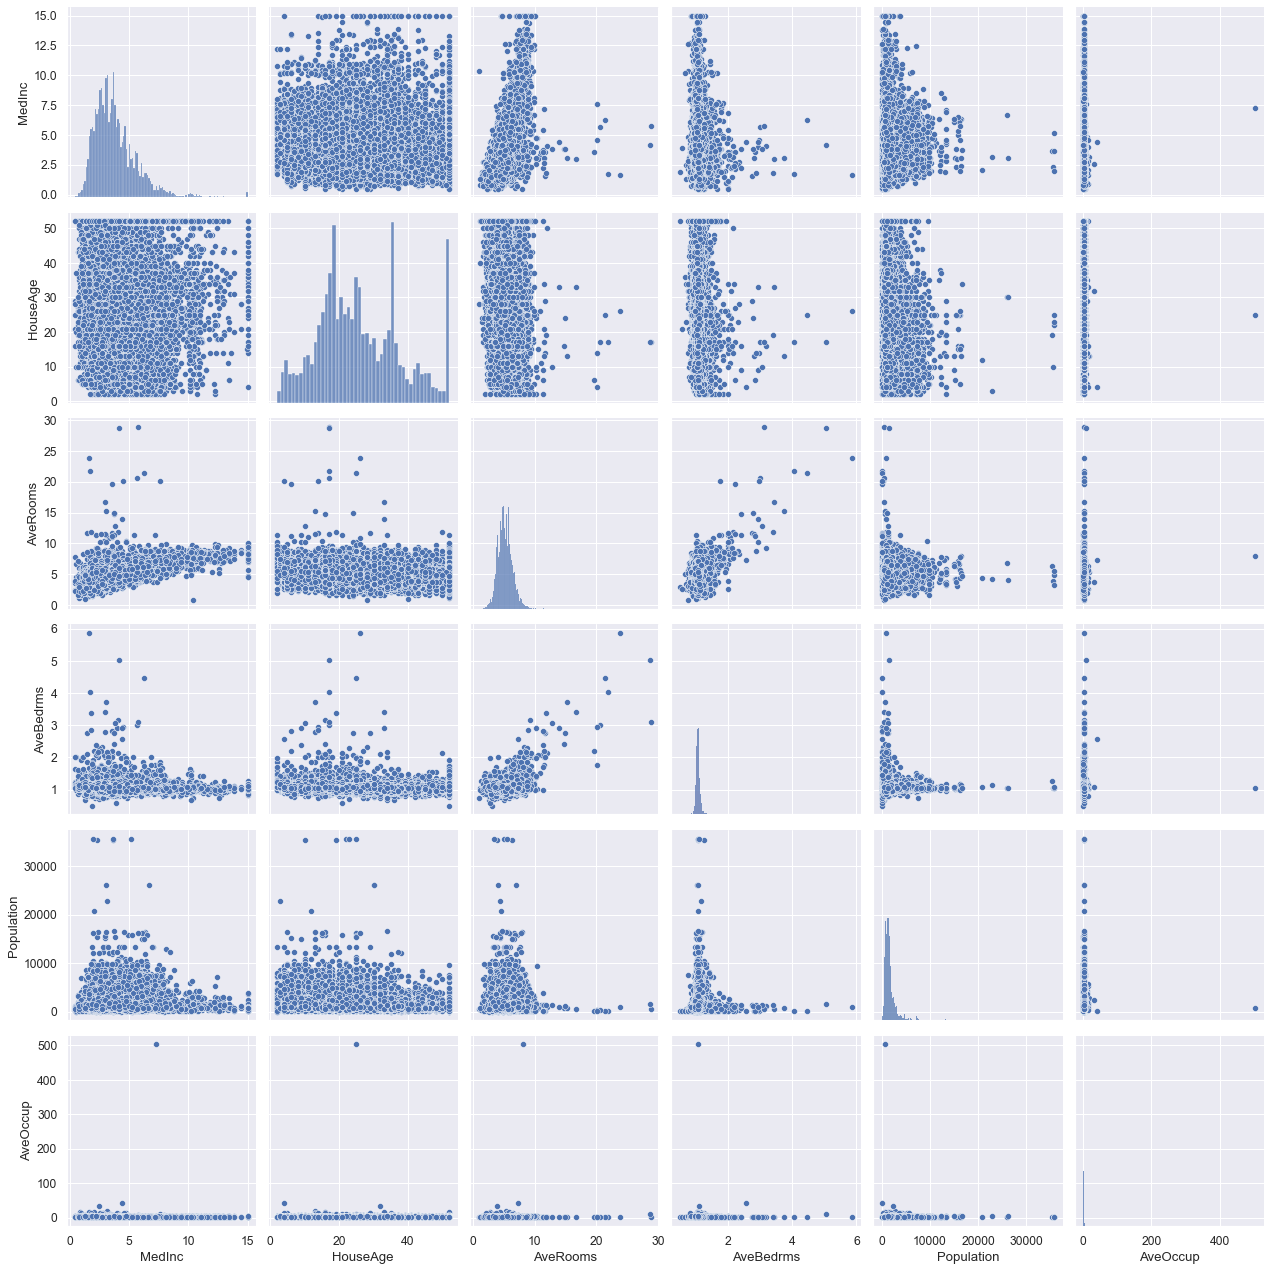

CPU times: user 16 s, sys: 191 ms, total: 16.2 s
Wall time: 17.4 s


In [22]:
%%time
if not Config.fast_render:
    X = train[cont_features].copy()
    sns.pairplot(data=train[cont_features].drop(columns=["Latitude", "Longitude"]), height=3, diag_kind="hist", palette=theme_palette)
#     sns.pairplot(train, height=3, diag_kind="hist")
    plt.show()

## Location Map

### References

- [Distance to Cities features & Clustering](https://www.kaggle.com/code/phongnguyen1/distance-to-cities-features-clustering)

In [23]:
heat_data = [[row['Latitude'],row['Longitude']] for _, row in train.iterrows()]
heat_map = Map(train[['Latitude', 'Longitude']].mean(axis=0), zoom_start=6) 
HeatMap(heat_data, radius=10).add_to(heat_map)
heat_map

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Feature Engineering</h1>
</div>

## References

- [PS S3E1 | Coordinates - key to victory](https://www.kaggle.com/code/dmitryuarov/ps-s3e1-coordinates-key-to-victory)

### Load Original California Housing Dataset

In [24]:
original_df = datasets.fetch_california_housing(as_frame=True)['frame']

train['is_generated'] = 1
test['is_generated'] = 1
original_df['is_generated'] = 0
train = pd.concat([train, original_df]).reset_index(drop=True)

In [25]:
# Source: https://www.kaggle.com/code/dmitryuarov/ps-s3e1-coordinates-key-to-victory?scriptVersionId=115523170&cellId=7

def crt_crds(df:pd.DataFrame) -> pd.DataFrame:
    df['rot_15_x'] = (np.cos(np.radians(15)) * df['Longitude']) + \
                      (np.sin(np.radians(15)) * df['Latitude'])
    
    df['rot_15_y'] = (np.cos(np.radians(15)) * df['Latitude']) + \
                      (np.sin(np.radians(15)) * df['Longitude'])
    
    df['rot_30_x'] = (np.cos(np.radians(30)) * df['Longitude']) + \
                      (np.sin(np.radians(30)) * df['Latitude'])
    
    df['rot_30_y'] = (np.cos(np.radians(30)) * df['Latitude']) + \
                      (np.sin(np.radians(30)) * df['Longitude'])
    
    df['rot_45_x'] = (np.cos(np.radians(45)) * df['Longitude']) + \
                      (np.sin(np.radians(45)) * df['Latitude'])
    return df

train = crt_crds(train)
test = crt_crds(test)

### Location of Coordinates

- https://www.kaggle.com/code/dmitryuarov/ps-s3e1-coordinates-key-to-victory


In [26]:
!pip install reverse_geocoder -q

In [27]:
import reverse_geocoder as rg

def geocoder(df):
    coordinates = list(zip(df['Latitude'], df['Longitude']))
    results = rg.search(coordinates)
    return results

def replace(x):
    if x in places:
        return x
    else:
        return 'Other'

results = geocoder(train)
train['place'] = [x['admin2'] for x in results]
results = geocoder(test)
test['place'] = [x['admin2'] for x in results]

places = ['Los Angeles County', 'Orange County', 'Kern County',
          'Alameda County', 'San Francisco County', 'Ventura County',
          'Santa Clara County', 'Fresno County', 'Santa Barbara County',
          'Contra Costa County', 'Yolo County', 'Monterey County',
          'Riverside County', 'Napa County']
    
train['place'] = train['place'].apply(lambda x: replace(x))
test['place'] = test['place'].apply(lambda x: replace(x))

le = preprocessing.LabelEncoder()

train['place'] = le.fit_transform(train['place'])
test['place'] = le.transform(test['place'])

Loading formatted geocoded file...


### Rotational Coordinates using PCA

In [28]:
from sklearn.decomposition import PCA

# https://www.kaggle.com/code/dmitryuarov/ps-s3e1-coordinates-key-to-victory

def pca_crds(df):
    coordinates = df[['Latitude', 'Longitude']].values
    pca_obj = PCA().fit(coordinates)
    df['pca_lat'] = pca_obj.transform(df[['Latitude', 'Longitude']].values)[:,0]
    df['pca_lon'] = pca_obj.transform(df[['Latitude', 'Longitude']].values)[:,1]
    return df

train = pca_crds(train)
test = pca_crds(test)

### Transform Skewed Data to make it Normal

In [29]:
#  'MedHouseVal'
for col in ['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude']:
    train[col] = np.log1p(train[col]-np.min(train[col]))

In [30]:
train.skew()

id               0.000000
MedInc           0.127800
HouseAge         0.285247
AveRooms         0.338953
AveBedrms       10.399753
Population      -0.909909
AveOccup         1.678677
Latitude        -0.057272
Longitude       -0.307736
MedHouseVal      0.973307
is_generated    -0.595879
rot_15_x        -0.316701
rot_15_y         0.571464
rot_30_x        -0.294314
rot_30_y         0.936921
rot_45_x         1.338616
place           -0.026621
pca_lat          0.341998
pca_lon          1.086197
dtype: float64

### KNN

- https://www.kaggle.com/code/oscarm524/ps-s3-ep1-eda-fe-modeling


### Extract all features after feature engineering

In [31]:
excluded_features = [TARGET, "id", "fold", "rot_30_y"]

In [32]:
cont_features, cat_features = feature_distribution_types(train, display=True)
show_cardinality(train, cat_features)

# cont_features.remove(TARGET)
# cont_features.remove("id")
# cont_features.remove("fold")
cont_features = [feature for feature in cont_features if feature not in excluded_features]
cat_features = [feature for feature in cat_features if feature not in excluded_features]

FEATURES = cont_features + cat_features
FEATURES

Continuous Features=['id', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal', 'is_generated', 'rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y', 'rot_45_x', 'place', 'pca_lat', 'pca_lon']

Categorical Features=[]
=== Cardinality ===
Series([], dtype: float64)


['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude',
 'is_generated',
 'rot_15_x',
 'rot_15_y',
 'rot_30_x',
 'rot_45_x',
 'place',
 'pca_lat',
 'pca_lon']

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Train Models with Cross Validation</h1>
</div>

In [33]:
train = create_folds(train, Config.N_FOLDS)

n_folds=10, seed=42


In [34]:
model_dict = {
    "lin_reg": linear_model.LinearRegression(),
    "lasso": linear_model.Lasso(),
    "ridge": linear_model.Ridge(max_iter=7000),
    "ridge_25": linear_model.Ridge(fit_intercept=True, solver='auto', alpha=0.25, max_iter=7000),
    "ridge_50": linear_model.Ridge(fit_intercept=True, solver='auto', alpha=0.5, max_iter=7000),
    "xgbr": xgb.XGBRegressor(
#         colsample_bytree=1,
        eta=0.01,
        max_depth=10,
        n_estimators=Config.N_ESTIMATORS,
        subsample=1,
        n_jobs=-1,
    ),
    "lgbm1": lgb.LGBMRegressor(
        learning_rate=0.1,
        max_depth=10,
        num_leaves=11,
        feature_fraction=0.3,
        subsample=0.1,
        n_jobs=-1,
    ),
    "cat1": cb.CatBoostRegressor(
        learning_rate=0.1,
        max_depth=10,
        iterations = Config.N_ESTIMATORS,
#         num_leaves=11,
#         feature_fraction=0.3,
        subsample=0.1,
#         n_jobs=-1,
    ),


}

## Model Support Library

In [35]:
all_cv_scores = pd.DataFrame(
    {
        "Model": pd.Series(dtype="str"),
        "Score": pd.Series(dtype="float"),
        "StdDev": pd.Series(dtype="float"),
    }
)

In [36]:
def show_tree_model_fi(model, features:List[str]) -> None:
    print("\n=== Model Feature Importance ===")
    for i in model.feature_importances_.argsort()[::-1]:
        print(features[i], model.feature_importances_[i]/model.feature_importances_.sum())

def save_oof_predictions(model_name:str, final_valid_predictions, oof:pd.DataFrame) -> pd.DataFrame:
    final_valid_predictions_df = process_valid_predictions(
        final_valid_predictions, "id", model_name
    )
    display(final_valid_predictions_df.head())
    oof[f"pred_{model_name}"] = final_valid_predictions_df[f"pred_{model_name}"]

    return oof

def save_test_predictions(model_name:str, final_test_predictions, submission_df:pd.DataFrame, result_field:str=TARGET) -> None:
    result = merge_test_predictions(final_test_predictions, Config.calc_probability)
    # result[:20]
    submission_df[f"target_{model_name}"] = result
    #     submission_df.head(10)
    ss = submission_df[["id", f"target_{model_name}"]].copy().reset_index(drop=True)
    ss.rename(columns={f"target_{model_name}": result_field}, inplace=True)
    ss.to_csv(
        f"submission_{model_name}.csv", index=False
    )  # Can submit the individual model
    ss.head(10)

def process_valid_predictions(final_valid_predictions, train_id, model_name:str) -> pd.DataFrame:
    model = f"pred_{model_name}"
    final_valid_predictions_df = pd.DataFrame.from_dict(
        final_valid_predictions, orient="index"
    ).reset_index()
    final_valid_predictions_df.columns = [train_id, model]
    final_valid_predictions_df.set_index(train_id, inplace=True)
    final_valid_predictions_df.sort_index(inplace=True)
    final_valid_predictions_df.to_csv(f"train_pred_{model_name}.csv", index=True)

    return final_valid_predictions_df

def add_score(score_df:pd.DataFrame, model_name:str, score:float, std:float):
    dict1 = {"Model": model_name, "Score": cv_score, "StdDev": std_dev}
    score_df = score_df.append(dict1, ignore_index=True)
    return score_df

In [37]:
def train_cv_model(
    df:pd.DataFrame,
    test:pd.DataFrame,
    get_model_fn,
    FEATURES:List[str],
    TARGET:str,
    calc_probability:bool,
    rowid,
    params,
    n_folds:int=5,
    seed:int=42,
):

    final_test_predictions = []
    final_valid_predictions = {}
    fold_scores = []  # Scores of Validation Set
    feature_importance_lst = []

    test = test[FEATURES].copy()

    for fold in range(n_folds):
        print(10 * "=", f"Fold {fold+1}/{n_folds}", 10 * "=")

        start_time = time.time()

        xtrain = df[df.fold != fold].reset_index(
            drop=True
        )  # Everything not in validation fold
        xvalid = df[df.fold == fold].reset_index(drop=True)
        xtest = test.copy()

        valid_ids = xvalid.id.values.tolist()  # Id's of everything in validation fold

        ytrain = xtrain[TARGET]
        yvalid = xvalid[TARGET]

        xtrain = xtrain[FEATURES]
        xvalid = xvalid[FEATURES]

#         scaler = preprocessing.StandardScaler()
        scaler = preprocessing.MinMaxScaler()
        xtrain = scaler.fit(xtrain).transform(xtrain)
        xvalid = scaler.transform(xvalid)
        xtest = scaler.transform(xtest)

        model = get_model_fn # ()

        model.fit(
            xtrain,
            ytrain,
        )
        if calc_probability:
            preds_valid = model.predict_proba(xvalid)[:, 1]
            test_preds = model.predict_proba(xtest)[:, 1]
        else:
            preds_valid = model.predict(xvalid)
            test_preds = model.predict(xtest)

        preds_valid_class = model.predict(xvalid)
        
        final_test_predictions.append(test_preds)
        final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))

        # fold_score = metrics.accuracy_score(yvalid, preds_valid_class)  # Validation Set Score
#         fold_score = metrics.roc_auc_score(yvalid, preds_valid)  # Validation Set Score
        fold_score = metrics.mean_squared_error(yvalid, preds_valid, squared=False)
        fold_scores.append(fold_score)
        #         importance_list.append(model.coef_.ravel())

        # Feature importance
        fi = pd.DataFrame(
            index=FEATURES,
            data=model.coef_.ravel(),
            columns=[f"{fold}_importance"],
        )
        feature_importance_lst.append(fi)

        run_time = time.time() - start_time

        print(f"fold: {fold+1}, RMSE: {fold_score}, Run Time: {run_time:.2f}")

    return (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    )


def train_xgb_model(
    df:pd.DataFrame,
    test:pd.DataFrame,
    get_model_fn,
    FEATURES:List[str],
    TARGET:str,
    calc_probability:bool,
    rowid:str,
    params,
    n_folds:int=5,
    seed:int=42,
):

    print(params)
    final_test_predictions = []
    final_valid_predictions = {}
    fold_scores = []  # Scores of Validation Set
    feature_importance_lst = []

    test = test[FEATURES].copy()

    for fold in range(n_folds):
        print(10 * "=", f"Fold {fold+1}/{n_folds}", 10 * "=")

        start_time = time.time()

        xtrain = df[df.fold != fold].reset_index(
            drop=True
        )  # Everything not in validation fold
        xvalid = df[df.fold == fold].reset_index(drop=True)
        xtest = test.copy()

        valid_ids = xvalid.id.values.tolist()  # Id's of everything in validation fold

        ytrain = xtrain[TARGET]
        yvalid = xvalid[TARGET]

        xtrain = xtrain[FEATURES]
        xvalid = xvalid[FEATURES]

        model = get_model_fn # (params)

        model.fit(
            xtrain,
            ytrain,
            eval_set=[(xvalid, yvalid)],
            #             eval_metric="acc",  # auc
            verbose=False,
            #             early_stopping_rounds=3000,
            #             callbacks=[
            #                 xgb.log_evaluation(0),
            #                 xgb.early_stopping(500, False, True),
            #             ],
        )

        # Mean of the predictions
        preds_valid = model.predict(xvalid)
        test_preds = model.predict(xtest)

        #         preds_valid = model.predict_proba(xvalid)[:, 1]
        #         test_preds = model.predict_proba(xtest)[:, 1]

        final_test_predictions.append(test_preds)
        final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))

        #         fold_score = accuracy_score(yvalid, preds_valid)  # Validation Set Score
        #         fold_score = roc_auc_score(yvalid, preds_valid)  # Validation Set Score
#         fold_score = metrics.mean_absolute_error(
#             yvalid, preds_valid
#         )  # Validation Set Score
        fold_score = metrics.mean_squared_error(yvalid, preds_valid, squared=False)
        fold_scores.append(fold_score)

        # Feature importance
        fi = pd.DataFrame(
            index=FEATURES,
            data=model.feature_importances_,
            columns=[f"{fold}_importance"],
        )
        feature_importance_lst.append(fi)

        run_time = time.time() - start_time

        print(f"fold: {fold+1}, Score: {fold_score}, Run Time: {run_time:.2f}")

    return (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    )        

In [38]:
def run_linear_model(model_name:str, features:List[str], oof:pd.DataFrame) -> (float, float, pd.DataFrame):
    (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    ) = train_cv_model(
        train,
        test,
        model_dict[model_name],
        features,
        TARGET,
        False, #Config.calc_probability,
        "id",
        {},
        Config.N_FOLDS,
        Config.seed,
    )

    cv_score, std_dev = show_fold_scores(fold_scores)

    oof = save_oof_predictions(model_name, final_valid_predictions, oof)
    oof.head()

#     save_test_predictions(model_name, final_test_predictions, "pred")
    save_test_predictions(model_name, final_test_predictions, sample_submission, TARGET)

    
    return cv_score, std_dev, oof

def run_tree_model(model_name:str, features:List[str], params, oof:pd.DataFrame) -> (float, float, pd.DataFrame):
    (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    ) = train_xgb_model(
        train,
        test,
        model_dict[model_name],
        features,
        TARGET,
        Config.calc_probability,
        "id",
        params,
        Config.N_FOLDS,
        Config.seed,
    )

    cv_score, std_dev = show_fold_scores(fold_scores)
    show_tree_model_fi(model, features)

    oof = save_oof_predictions(model_name, final_valid_predictions, oof)
    oof.head()

    save_test_predictions(model_name, final_test_predictions, sample_submission, TARGET)

    return cv_score, std_dev, oof

In [39]:
oof = train[["id", TARGET, "fold"]].copy().reset_index(drop=True).copy()
oof.set_index("id", inplace=True)
oof.head()

,MedHouseVal,fold
id,,
0.0,0.980,3
1.0,0.946,2
2.0,1.576,8
3.0,1.336,4
4.0,4.500,0


## Linear Models

In [40]:
%%time
def run_linear_models4features(model_lst:List[str], target:str, feature_lst:List[str], all_cv_scores:pd.DataFrame) -> pd.DataFrame:

    oof = train[["id", target, "fold"]].copy().reset_index(drop=True).copy()
    oof.set_index("id", inplace=True)

    for idx, m in enumerate(model_lst):
        model = model_lst[idx]
        print(f"Model={model}")

        cv_score, std_dev, oof = run_linear_model(model, feature_lst, oof)
        dict1 = {"Model": model, "Score": cv_score, "StdDev": std_dev}
        all_cv_scores = all_cv_scores.append(dict1, ignore_index=True)
        
    return all_cv_scores

model_lst = ["lin_reg", "lasso", "ridge", "ridge_25", "ridge_50"]

all_cv_scores = run_linear_models4features(model_lst, TARGET, FEATURES, all_cv_scores)    
all_cv_scores.head()

Model=lin_reg
========== Fold 1/10 ==========
fold: 1, RMSE: 0.7096287844770667, Run Time: 0.17
========== Fold 2/10 ==========
fold: 2, RMSE: 0.7000613926845585, Run Time: 0.32
========== Fold 3/10 ==========
fold: 3, RMSE: 0.7262983843679065, Run Time: 0.46
========== Fold 4/10 ==========
fold: 4, RMSE: 0.7113431073754528, Run Time: 0.53
========== Fold 5/10 ==========
fold: 5, RMSE: 0.7389768855378515, Run Time: 0.48
========== Fold 6/10 ==========
fold: 6, RMSE: 0.6949240881281509, Run Time: 0.73
========== Fold 7/10 ==========
fold: 7, RMSE: 0.7240884016323269, Run Time: 0.73
========== Fold 8/10 ==========
fold: 8, RMSE: 0.7271317835086184, Run Time: 0.92
========== Fold 9/10 ==========
fold: 9, RMSE: 0.7243341693488248, Run Time: 0.83
========== Fold 10/10 ==========
fold: 10, RMSE: 0.7162431589291183, Run Time: 0.92
Scores -> Adjusted: 0.70451089 , mean: 0.71730302, std: 0.01279212


,pred_lin_reg
id,
0.0,2.251953
1.0,1.101562
2.0,3.421875
3.0,1.699219
4.0,3.279297


Mean
Model=lasso
========== Fold 1/10 ==========
fold: 1, RMSE: 1.1430307982075059, Run Time: 0.12
========== Fold 2/10 ==========


<timed exec>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


fold: 2, RMSE: 1.1626092195428503, Run Time: 0.22
========== Fold 3/10 ==========
fold: 3, RMSE: 1.1624385267294208, Run Time: 0.25
========== Fold 4/10 ==========
fold: 4, RMSE: 1.1368485165739715, Run Time: 0.41
========== Fold 5/10 ==========
fold: 5, RMSE: 1.1672159452144317, Run Time: 0.45
========== Fold 6/10 ==========
fold: 6, RMSE: 1.161456650280366, Run Time: 0.60
========== Fold 7/10 ==========
fold: 7, RMSE: 1.1707931917360148, Run Time: 0.72
========== Fold 8/10 ==========
fold: 8, RMSE: 1.1610061976775679, Run Time: 0.92
========== Fold 9/10 ==========
fold: 9, RMSE: 1.1663186754392776, Run Time: 0.80
========== Fold 10/10 ==========
fold: 10, RMSE: 1.136973554686472, Run Time: 0.91
Scores -> Adjusted: 1.14470148 , mean: 1.15686913, std: 0.01216764


,pred_lasso
id,
0.0,2.077851
1.0,2.075723
2.0,2.074941
3.0,2.073901
4.0,2.075399


Mean
Model=ridge
========== Fold 1/10 ==========
fold: 1, RMSE: 0.7097115087308545, Run Time: 0.12
========== Fold 2/10 ==========


<timed exec>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


fold: 2, RMSE: 0.7006030037285432, Run Time: 0.20
========== Fold 3/10 ==========
fold: 3, RMSE: 0.7262311981823841, Run Time: 0.25
========== Fold 4/10 ==========
fold: 4, RMSE: 0.7114354109220162, Run Time: 0.40
========== Fold 5/10 ==========
fold: 5, RMSE: 0.7385877902801344, Run Time: 0.45
========== Fold 6/10 ==========
fold: 6, RMSE: 0.6950173022071454, Run Time: 0.59
========== Fold 7/10 ==========
fold: 7, RMSE: 0.7243702518864537, Run Time: 0.72
========== Fold 8/10 ==========
fold: 8, RMSE: 0.727206789286629, Run Time: 0.92
========== Fold 9/10 ==========
fold: 9, RMSE: 0.7247368115457216, Run Time: 0.80
========== Fold 10/10 ==========
fold: 10, RMSE: 0.7169896993446907, Run Time: 0.90
Scores -> Adjusted: 0.70482643 , mean: 0.71748898, std: 0.01266255


,pred_ridge
id,
0.0,2.247077
1.0,1.082492
2.0,3.417489
3.0,1.689898
4.0,3.275176


Mean
Model=ridge_25
========== Fold 1/10 ==========
fold: 1, RMSE: 0.7097234321417215, Run Time: 0.11
========== Fold 2/10 ==========


<timed exec>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


fold: 2, RMSE: 0.7004390531881293, Run Time: 0.21
========== Fold 3/10 ==========
fold: 3, RMSE: 0.7262870303518726, Run Time: 0.25
========== Fold 4/10 ==========
fold: 4, RMSE: 0.7114988545280427, Run Time: 0.40
========== Fold 5/10 ==========
fold: 5, RMSE: 0.738619760387139, Run Time: 0.45
========== Fold 6/10 ==========
fold: 6, RMSE: 0.6950048522033421, Run Time: 0.59
========== Fold 7/10 ==========
fold: 7, RMSE: 0.7242805194627303, Run Time: 0.75
========== Fold 8/10 ==========
fold: 8, RMSE: 0.7271986616767369, Run Time: 0.91
========== Fold 9/10 ==========
fold: 9, RMSE: 0.7246818172294965, Run Time: 0.80
========== Fold 10/10 ==========
fold: 10, RMSE: 0.7168563676061239, Run Time: 0.90
Scores -> Adjusted: 0.70477492 , mean: 0.71745903, std: 0.01268412


,pred_ridge_25
id,
0.0,2.250296
1.0,1.077142
2.0,3.416643
3.0,1.689440
4.0,3.284905


Mean
Model=ridge_50
========== Fold 1/10 ==========
fold: 1, RMSE: 0.7097152874294308, Run Time: 0.11
========== Fold 2/10 ==========


<timed exec>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


fold: 2, RMSE: 0.7004905840606969, Run Time: 0.21
========== Fold 3/10 ==========
fold: 3, RMSE: 0.7262646135522092, Run Time: 0.25
========== Fold 4/10 ==========
fold: 4, RMSE: 0.7114733461259921, Run Time: 0.40
========== Fold 5/10 ==========
fold: 5, RMSE: 0.7386044464594677, Run Time: 0.45
========== Fold 6/10 ==========
fold: 6, RMSE: 0.6950051884611886, Run Time: 0.59
========== Fold 7/10 ==========
fold: 7, RMSE: 0.7243064571303722, Run Time: 0.72
========== Fold 8/10 ==========
fold: 8, RMSE: 0.727197032397383, Run Time: 0.91
========== Fold 9/10 ==========
fold: 9, RMSE: 0.7246961901239297, Run Time: 0.82
========== Fold 10/10 ==========
fold: 10, RMSE: 0.7168970917964855, Run Time: 0.90
Scores -> Adjusted: 0.70478838 , mean: 0.71746502, std: 0.01267664


,pred_ridge_50
id,
0.0,2.249205
1.0,1.078940
2.0,3.416948
3.0,1.689594
4.0,3.281618


Mean
CPU times: user 41.5 s, sys: 7.16 s, total: 48.7 s
Wall time: 28.8 s


<timed exec>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Model,Score,StdDev
0,lin_reg,0.717303,0.012792
1,lasso,1.156869,0.012168
2,ridge,0.717489,0.012663
3,ridge_25,0.717459,0.012684
4,ridge_50,0.717465,0.012677


## Tree Models

In [41]:
%%time

def run_tree_models4features(model_lst:List[str], target:str, feature_lst:List[str], all_cv_scores:pd.DataFrame) -> pd.DataFrame:

    oof = train[["id", target, "fold"]].copy().reset_index(drop=True).copy()
    oof.set_index("id", inplace=True)

    for idx, m in enumerate(model_lst):
        model = model_lst[idx]
        print(f"Model={model}")

        params = {}
        cv_score, std_dev, oof = run_tree_model(model, feature_lst, params, oof)
        score_dict = {"Model": model, "Score": cv_score, "StdDev": std_dev}
        all_cv_scores = all_cv_scores.append(score_dict, ignore_index=True)
        
    return all_cv_scores

model_lst = ["xgbr","lgbm1", "cat1"]
all_cv_scores = run_tree_models4features(model_lst, TARGET, FEATURES, all_cv_scores)    

all_cv_scores.sort_values(by=["Score"], ascending=False)


Model=xgbr
{}
========== Fold 1/10 ==========
fold: 1, Score: 0.5110411348002594, Run Time: 94.12
========== Fold 2/10 ==========
fold: 2, Score: 0.5105931811784292, Run Time: 95.88
========== Fold 3/10 ==========
fold: 3, Score: 0.5263173889278492, Run Time: 94.01
========== Fold 4/10 ==========
fold: 4, Score: 0.5180100267012027, Run Time: 95.37
========== Fold 5/10 ==========
fold: 5, Score: 0.5331517662083569, Run Time: 98.30
========== Fold 6/10 ==========
fold: 6, Score: 0.49552045203758194, Run Time: 93.60
========== Fold 7/10 ==========
fold: 7, Score: 0.5350905371699498, Run Time: 92.94
========== Fold 8/10 ==========
fold: 8, Score: 0.5390323128005231, Run Time: 92.40
========== Fold 9/10 ==========
fold: 9, Score: 0.528198517126823, Run Time: 106.82
========== Fold 10/10 ==========
fold: 10, Score: 0.5130066496841043, Run Time: 114.07
Scores -> Adjusted: 0.50803090 , mean: 0.52099620, std: 0.01296529

=== Model Feature Importance ===
rot_45_x 0.3633123
MedInc 0.22512387
AveO

,pred_xgbr
id,
0.0,1.928999
1.0,1.340674
2.0,2.401098
3.0,1.157777
4.0,3.778418


Mean
Model=lgbm1
{}
========== Fold 1/10 ==========
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3


<timed exec>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


fold: 1, Score: 0.5311385310681647, Run Time: 2.31
========== Fold 2/10 ==========
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
fold: 2, Score: 0.5294264092172027, Run Time: 1.58
========== Fold 3/10 ==========
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
fold: 3, Score: 0.5503851994237994, Run Time: 3.14
========== Fold 4/10 ==========
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
fold: 4, Score: 0.5400541028724896, Run Time: 1.81
========== Fold 5/10 ==========
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
fold: 5, Score: 0.5619059807657543, Run Time: 3.37
========== Fold 6/10 ==========
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. C

,pred_lgbm1
id,
0.0,1.925144
1.0,1.326791
2.0,2.340377
3.0,1.208664
4.0,3.475908


Mean
Model=cat1
{}
========== Fold 1/10 ==========


<timed exec>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


fold: 1, Score: 0.5166438359519044, Run Time: 11.24
========== Fold 2/10 ==========
fold: 2, Score: 0.509557565358361, Run Time: 10.07
========== Fold 3/10 ==========
fold: 3, Score: 0.5288584750177515, Run Time: 10.34
========== Fold 4/10 ==========
fold: 4, Score: 0.5231952279674765, Run Time: 11.61
========== Fold 5/10 ==========
fold: 5, Score: 0.5395651258929831, Run Time: 11.24
========== Fold 6/10 ==========
fold: 6, Score: 0.4992645434713979, Run Time: 10.44
========== Fold 7/10 ==========
fold: 7, Score: 0.5346864313842024, Run Time: 10.68
========== Fold 8/10 ==========
fold: 8, Score: 0.5437969083038678, Run Time: 10.64
========== Fold 9/10 ==========
fold: 9, Score: 0.5309057758712115, Run Time: 10.55
========== Fold 10/10 ==========
fold: 10, Score: 0.5188120711612508, Run Time: 10.66
Scores -> Adjusted: 0.51141756 , mean: 0.52452860, std: 0.01311104

=== Model Feature Importance ===
MedInc 0.2739534700736575
AveOccup 0.12141179237334926
rot_45_x 0.11026272185274064
HouseA

,pred_cat1
id,
0.0,1.676746
1.0,1.337000
2.0,2.481480
3.0,0.918991
4.0,3.586310


Mean
CPU times: user 1h 7min 44s, sys: 10min 40s, total: 1h 18min 24s
Wall time: 18min 28s


<timed exec>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Model,Score,StdDev
1,lasso,1.156869,0.012168
2,ridge,0.717489,0.012663
4,ridge_50,0.717465,0.012677
3,ridge_25,0.717459,0.012684
0,lin_reg,0.717303,0.012792
6,lgbm1,0.543728,0.013839
7,cat1,0.524529,0.013111
5,xgbr,0.520996,0.012965


<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Blend Models</h1>
</div>

In [42]:
train_oof_dict = {
    "train_pred_cat1": "train_pred_cat1.csv",
    "train_pred_lgbm1": "train_pred_lgbm1.csv",    
    "train_pred_xgbr": "train_pred_xgbr.csv"
}

test_pred_dict = {
    "submission_cat1": "submission_cat1.csv",
    "submission_lgbm1": "submission_lgbm1.csv",
    "submission_xgbr": "submission_xgbr.csv",
}

In [45]:
def blend_results():
    oof_df = pd.DataFrame()
    test_preds_df = pd.DataFrame()

    for name, train_oof_fname in train_oof_dict.items():
        fname = "" + train_oof_fname
        print(f"Processing {name}, {train_oof_fname}")
        df = pd.read_csv(fname)
        print(df.head())
#         print(df.iloc[:,1])
        preds = pd.Series(df.iloc[:,1], name=name)
#         print(preds[:5])
        oof_df = pd.concat([oof_df, preds], axis=1)
    #     oof_df = pd.concat([oof_df, pd.Series(np.load(TRAIN_PATH / train_oof), name=name)], axis=1)

    for name, test_pred_fname in test_pred_dict.items():
        fname = "" + train_oof_fname
        print(f"{name}, {test_pred_fname}")
        df = pd.read_csv(fname)
        print(df.head())
        preds = pd.Series(df.iloc[:,1], name=name)
        test_preds_df = pd.concat([test_preds_df, preds], axis=1)



    print("=== oof ===")
    print(oof_df.head())
    print("=== test_preds ===")
    print(test_preds_df.head())
    return oof_df, test_preds_df
    
(oof_df, preds_df) = blend_results()    

Processing train_pred_cat1, train_pred_cat1.csv
    id  pred_cat1
0  0.0   1.676746
1  1.0   1.337000
2  2.0   2.481480
3  3.0   0.918991
4  4.0   3.586310
Processing train_pred_lgbm1, train_pred_lgbm1.csv
    id  pred_lgbm1
0  0.0    1.925144
1  1.0    1.326791
2  2.0    2.340377
3  3.0    1.208664
4  4.0    3.475908
Processing train_pred_xgbr, train_pred_xgbr.csv
    id  pred_xgbr
0  0.0   1.928999
1  1.0   1.340674
2  2.0   2.401098
3  3.0   1.157777
4  4.0   3.778418
submission_cat1, submission_cat1.csv
    id  pred_xgbr
0  0.0   1.928999
1  1.0   1.340674
2  2.0   2.401098
3  3.0   1.157777
4  4.0   3.778418
submission_lgbm1, submission_lgbm1.csv
    id  pred_xgbr
0  0.0   1.928999
1  1.0   1.340674
2  2.0   2.401098
3  3.0   1.157777
4  4.0   3.778418
submission_xgbr, submission_xgbr.csv
    id  pred_xgbr
0  0.0   1.928999
1  1.0   1.340674
2  2.0   2.401098
3  3.0   1.157777
4  4.0   3.778418
=== oof ===
   train_pred_cat1  train_pred_lgbm1  train_pred_xgbr
0         1.676746   

In [46]:
all_blend_scores = pd.DataFrame(
    {
        "Model": pd.Series(dtype="str"),
        "Score": pd.Series(dtype="float"),
        "StdDev": pd.Series(dtype="float"),
    }
)

In [47]:
sample_submission.head()

,id,MedHouseVal,target_lin_reg,target_lasso,target_ridge,target_ridge_25,target_ridge_50,target_xgbr,target_lgbm1,target_cat1
0,37137,2.079751,1.366425e+10,2.075753,-11.279946,-10.041471,-10.458831,1.505438,1.564842,1.569370
1,37138,2.079751,1.136534e+10,2.075753,-34.349736,-32.379893,-33.044795,2.002759,2.033586,2.360406
2,37139,2.079751,1.094401e+10,2.075753,-6.673167,-5.287405,-5.754749,4.375095,4.202365,4.057786
3,37140,2.079751,1.136272e+10,2.075753,7.990328,8.768548,8.506615,4.602870,4.275218,4.606652
4,37141,2.079751,1.130991e+10,2.075753,-81.895246,-78.009226,-79.322143,4.447911,4.285762,4.402809


In [48]:
sample_submission[TARGET] = (
    (sample_submission["target_xgbr"] * 2 )
    + (sample_submission["target_lgbm1"])
    + (sample_submission["target_cat1"] )
)/4

## Clip target value

- [Clip Max (Boost +0.003)](https://www.kaggle.com/competitions/playground-series-s3e1/discussion/376396)

In [50]:
sample_submission.loc[sample_submission.MedHouseVal.gt(5), "MedHouseVal"] = 5

In [51]:
sample_submission[["id", TARGET]].to_csv("blend_model_submission_wt_avg.csv", index=False)
sample_submission[["id", TARGET]].head(8)

,id,MedHouseVal
0,37137,1.536272
1,37138,2.099878
2,37139,4.252586
3,37140,4.521903
4,37141,4.396098
5,37142,4.280285
6,37143,3.941212
7,37144,4.092540


In [53]:
sample_submission[TARGET] = (
    (sample_submission["target_xgbr"] )
    + (sample_submission["target_lgbm1"])
    + (sample_submission["target_cat1"]  )
)/3

In [54]:
sample_submission[["id", TARGET]].to_csv("blend_model_submission_even_wt_avg.csv", index=False)
sample_submission[["id", TARGET]].head(8)

,id,MedHouseVal
0,37137,1.546550
1,37138,2.132251
2,37139,4.211749
3,37140,4.494913
4,37141,4.378827
5,37142,4.212526
6,37143,3.875100
7,37144,4.119467


In [55]:
all_cv_scores.sort_values(by=["Score"], ascending=False)

,Model,Score,StdDev
1,lasso,1.156869,0.012168
2,ridge,0.717489,0.012663
4,ridge_50,0.717465,0.012677
3,ridge_25,0.717459,0.012684
0,lin_reg,0.717303,0.012792
6,lgbm1,0.543728,0.013839
7,cat1,0.524529,0.013111
5,xgbr,0.520996,0.012965


In [56]:
all_blend_scores.sort_values(by=["Score"], ascending=False)

,Model,Score,StdDev
